In [26]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import time

1 - INPUT DATA

In [27]:
# Physical Data
L = 10.0
H = 10.0
V_in = 2
P_in = 101325
T_in = 293
gamma = 1.4
Rho_in = 1.204

# Numeral Data
N = 50
M = 50
delta = 0.000001
Psi_in = random.randint(1,10)
delta_N = L/N
delta_M = H/M

PREVIOUS CALCULATION

In [28]:
# Mesh Generation
X_cv = np.zeros(N+1)
Y_cv = np.zeros (M+1)

for i in range(1,N+1):
    X_cv[i] = X_cv[i-1] + delta_N


for j in range(1, M+1):
    Y_cv[j] = Y_cv[j-1] + delta_M



# Internal Nodes
X_p = np.zeros(N)
Y_p = np.zeros(M)

for i in range(N):
    X_p[i] = (X_cv[i+1] + X_cv[i])/2 


for j in range(M):
    Y_p[j] = (Y_cv[j+1] + Y_cv[j])/2 



# Mesh Generation
X_P = np.zeros(N+2)
Y_P = np.zeros (M+2)

X_P[0] = X_cv[0]
X_P[-1] = X_cv[-1]
Y_P[0] = Y_cv[0]
Y_P[-1] = Y_cv[-1]
for i in range (1, N+1):
    X_P[i] = X_p[i-1]
for j in range (1, M+1):
    Y_P[j] = Y_p[j-1]

# Cylinder
D = 2.0
x0 = L/2.0
y0 = H/2.0

# Define Metrics
Psi = np.zeros((M+2,N+2))
Psi_aux = np.zeros((M+2,N+2))
Rho = np.zeros((M+2,N+2))
a_E = np.zeros((M+2,N+2))
a_W = np.zeros((M+2,N+2))
a_S = np.zeros((M+2,N+2))
a_N = np.zeros((M+2,N+2))
b_P = np.zeros((M+2,N+2))
a_P = np.zeros((M+2,N+2))


INITIAL MAP

In [29]:
# Outlet nodes
for i in range(0,N+2):
    Psi[0][i] = Psi_in
    Psi[-1][i] = Psi_in
    Psi_aux[0][i] = Psi_in
    Psi_aux[-1][i] = Psi_in

# Inlet nodes
for i in range(0,N+2):
    for j in range(0,M+2):
        Psi[j][i] = Psi_in
        Psi_aux[j][i] = Psi_in
        Rho[j][i] = Rho_in

# Cylinder Body
I_cyl = np.zeros((M+2, N+2))
for i in range (N+2):
    for j in range (M+2):
        distance = ((X_P[i]-x0)**2 + (Y_P[j]-y0)**2)**(1/2)
        if distance <= (D/2):
            I_cyl[j][i] = 1
        else:
            I_cyl[j][i] = 0

#print(I_cyl)

EVALUATION DISCRETIZATION COEFFICIENTS

In [30]:
# Bottom nodes
for i in range(0,N+2):
    a_E[0][i] = 0
    a_W[0][i] = 0
    a_N[0][i] = 0
    a_S[0][i] = 0
    a_P[0][i] = 1
    b_P[0][i] = 0
    Psi[0][i] = b_P[0][i]

# Top Nodes
for i in range(0,N+2):
    a_E[-1][i] = 0
    a_W[-1][i] = 0
    a_N[-1][i] = 0
    a_S[-1][i] = 0
    a_P[-1][i] = 1
    b_P[-1][i] = V_in*H
    Psi[-1][i] = b_P[-1][i]

# Inlet nodes
for i in range(0,N+2):
    for j in range(1,M+1):
        Psi[j][i] = V_in * Y_p[j-1]

# Cylinder Nodes
for i in range (N+2):
    for j in range (M+2):
        if I_cyl[j][i] == 1:
            Psi[j][i] = V_in*H/2

#print(Psi)

#plt.contour(Psi, levels = 50, colors='b', linestyles='solid')
#plt.title('Stream Function')
#plt.xlabel('L')
#plt.ylabel('H')
#plt.grid()
#
## Mostrar el gráfico
#plt.show()

GAUSS-SEIDEL METHOD

In [31]:
r = 1.0
while r > delta:
    suma = 0.0
    suma_aux = 0.0
   
    for i in range (0, N+2):
        for j in range (0, M+2):
            if I_cyl[j][i]==1:
                Psi[j][i] = V_in*H/2
            else:
                Psi[j][i] = Psi_aux[j][i]
            a_E[j][i] = 0
            a_W[j][i] = 0
            a_N[j][i] = 0
            a_S[j][i] = 0
            a_P[j][i] = 0
            b_P[j][i] = 0

    ### TOP & BOTTOM
    # Top
    for i in range (0, N+2):
        a_E[-1][i] = 0
        a_W[-1][i] = 0
        a_N[-1][i] = 0
        a_S[-1][i] = 0
        a_P[-1][i] = 1
        b_P[-1][i] = V_in * H
        Psi[-1][i] = b_P[-1][i]

    # Bottom
    for i in range (0, N+2):
        a_E[0][i] = 0
        a_W[0][i] = 0
        a_N[0][i] = 0
        a_S[0][i] = 0
        a_P[0][i] = 1
        b_P[0][i] = 0
        Psi[0][i] = 0

    ### INLET & OUTLET FLOWS
    # Inlet
    for j in range (1, M+1):
        a_E[j][0] = 0
        a_W[j][0] = 0
        a_N[j][0] = 0
        a_S[j][0] = 0
        a_P[j][0] = 1
        b_P[j][0] = V_in * Y_p[j-1]
        Psi[j][0] = b_P[j][0]

    # Outlet
    for j in range (1, M+1):
        a_E[j][-1] = 0
        a_W[j][-1] = 1
        a_N[j][-1] = 0
        a_S[j][-1] = 0
        a_P[j][-1] = 1
        b_P[j][-1] = 0
        Psi[j][-1] = Psi[j][-2]

    # Internal Nodes
    for i in range (1, N+1):
        for j in range (1, M+1):
            a_E[j][i] = (Rho_in/Rho[j][i+1])*(delta_M/(np.abs(X_P[i+1]-X_P[i])))
            a_W[j][i] = (Rho_in/Rho[j][i-1])*(delta_M/(np.abs(X_P[i]-X_P[i-1])))
            a_N[j][i] = (Rho_in/Rho[j+1][i])*(delta_N/(np.abs(Y_P[j+1]-Y_P[j])))
            a_S[j][i] = (Rho_in/Rho[j-1][i])*(delta_N/(np.abs(Y_P[j]-Y_P[j-1])))
            a_P[j][i] = a_E[j][i] + a_W[j][i] + a_N[j][i] + a_S[j][i]
            b_P[j][i] = 0
            Psi[j][i] = (a_E[j][i]*Psi[j][i+1] + a_W[j][i]*Psi[j][i-1] + a_N[j][i]*Psi[j+1][i] + a_S[j][i]*Psi[j-1][i])/a_P[j][i]
            Psi[j][-1] = Psi[j][-2]

    for i in range (0, N+2):
        for j in range (0, M+2):
            suma = suma + Psi[j][i]
            suma_aux = suma_aux + Psi_aux[j][i]

    average = suma / (N*M)
    average_aux = suma_aux /(N*M)
    r = np.abs(average-average_aux)

    if r < delta:
        break

    for i in range (N+2):
        for j in range (M+2):
            Psi_aux[j][i] = Psi[j][i]

    #print(Psi)


PLOT

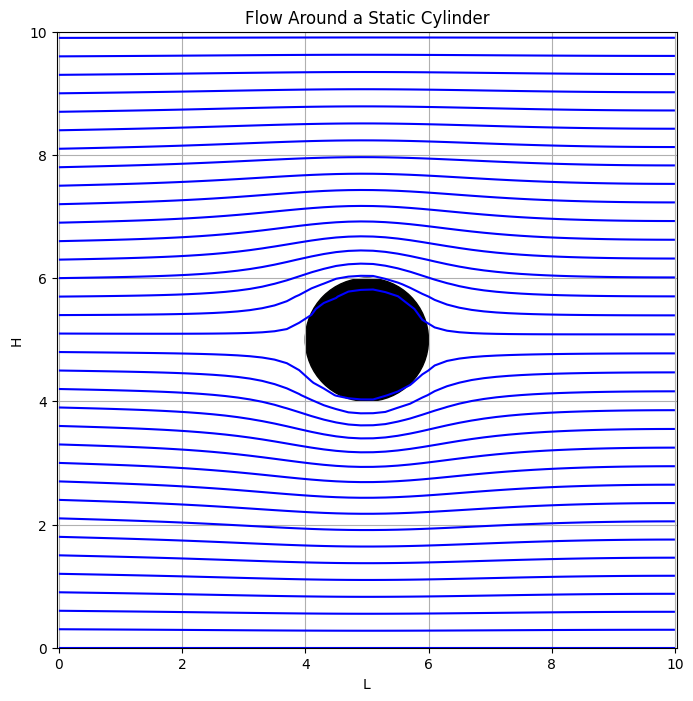

In [51]:
plt.figure(figsize=(8, 8))
plt.contour(X_P, Y_P, Psi, levels = 38, colors='b', linestyles='solid')
circle = plt.Circle((L/2, H/2), D/2, color='black', fill=True)
plt.gca().add_patch(circle)
plt.axis('equal')
plt.title('Flow Around a Static Cylinder')
plt.xlabel('L')
plt.ylabel('H')
plt.grid()
plt.show()



FINAL CALCULATIONS

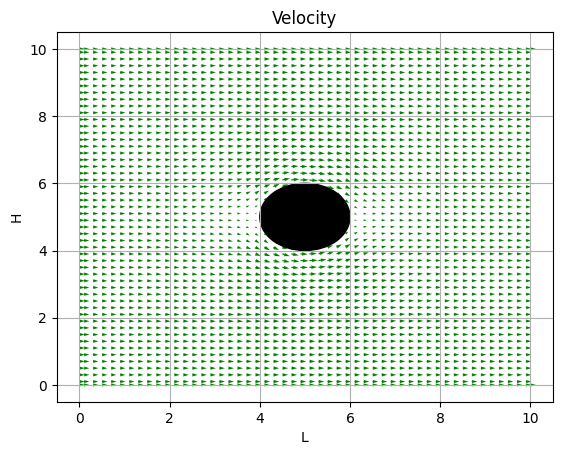

In [48]:
# Velocities
V_E = np.zeros((M+2,N+2))
V_W = np.zeros((M+2,N+2))
V_N = np.zeros((M+2,N+2))
V_S = np.zeros((M+2,N+2))
V_X = np.zeros((M+2,N+2))
V_Y = np.zeros((M+2,N+2))
V_P = np.zeros((M+2,N+2))



### TOP & BOTTOM
# Top
for i in range (0, N+2):
    V_E[-1][i] = 0
    V_W[-1][i] = 0
    V_N[-1][i] = 0
    V_S[-1][i] = 0
    V_X[-1][i] = V_in
    V_Y[-1][i] = 0
    V_P[-1][i] = np.sqrt((V_X[-1][i])**2 + (V_Y[-1][i])**2)
    
# Bottom
for i in range (0, N+2):
    V_E[0][i] = 0
    V_W[0][i] = 0
    V_N[0][i] = 0
    V_S[0][i] = 0
    V_X[0][i] = V_in
    V_Y[0][i] = 0
    V_P[0][i] = np.sqrt((V_X[0][i])**2 + (V_Y[0][i])**2)

    
### INLET & OUTLET FLOWS
# Inlet
for j in range (1, M+1):
    V_E[j][0] = 0
    V_W[j][0] = 0
    V_N[j][0] = 0
    V_S[j][0] = 0
    V_X[j][0] = V_in
    V_Y[j][0] = 0
    V_P[j][0] = np.sqrt((V_X[j][0])**2 + (V_Y[j][0])**2)

# Outlet
for j in range (1, M+1):
    V_E[j][-1] = 0
    V_W[j][-1] = 0
    V_N[j][-1] = 0
    V_S[j][-1] = 0
    V_X[j][-1] = V_X[j][-2]
    V_Y[j][-1] = 0
    V_P[j][-1] = np.sqrt((V_X[j][-1])**2 + (V_Y[j][-1])**2)

# Internal Nodes
for i in range (1, N+1):
    for j in range (1, M+1):
        V_E[j][i] = -(Psi[j][i+1]-Psi[j][i]) / np.abs(X_P[i+1]-X_P[i])
        V_W[j][i] = (Psi[j][i-1]-Psi[j][i]) / np.abs(X_P[i]-X_P[i-1])
        V_N[j][i] = (Psi[j+1][i]-Psi[j][i]) / np.abs(Y_P[j+1]-Y_P[j])
        V_S[j][i] = -(Psi[j-1][i]-Psi[j][i]) / np.abs(Y_P[j-1]-Y_P[j])
        V_X[j][i] = (V_N[j][i] + V_S[j][i])/2
        V_Y[j][i] = (V_E[j][i] + V_W[j][i])/2
        V_P[j][i] = np.sqrt((V_X[j][i])**2 + (V_Y[j][i])**2)


fig, ax = plt.subplots()
q = ax.quiver(X_P, Y_P, V_X, V_Y, color = 'green')
circle = plt.Circle((L/2, H/2), D/2, color='black', fill=True)
plt.gca().add_patch(circle)

ax.set_title('Velocity')
ax.set_xlabel('L')
ax.set_ylabel('H')
ax.grid()

# Mostrar el gráfico
plt.show()

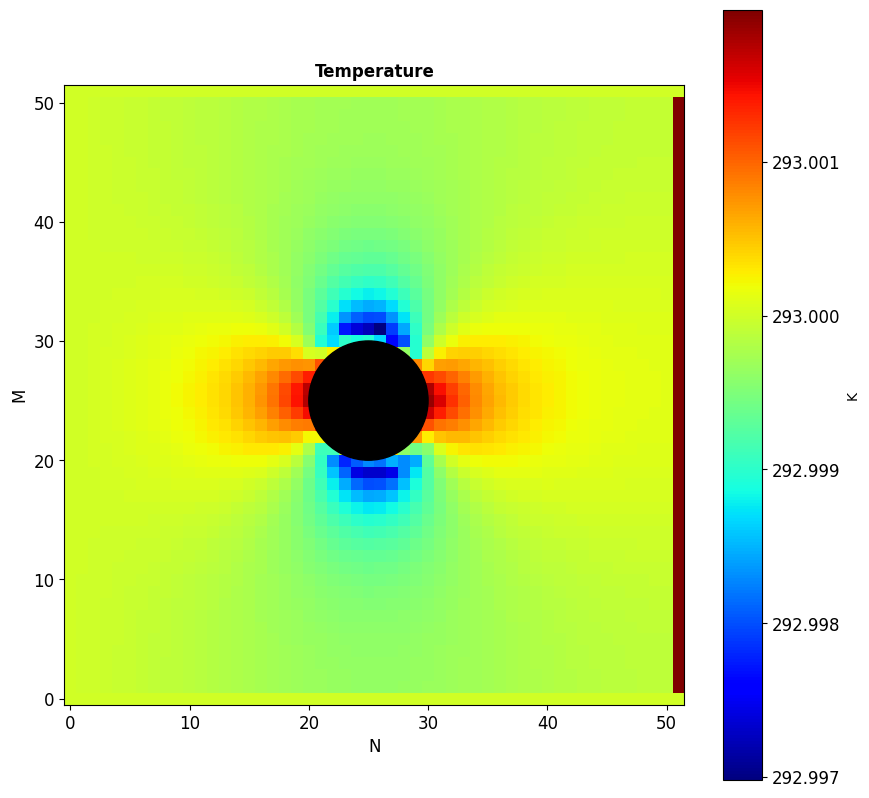

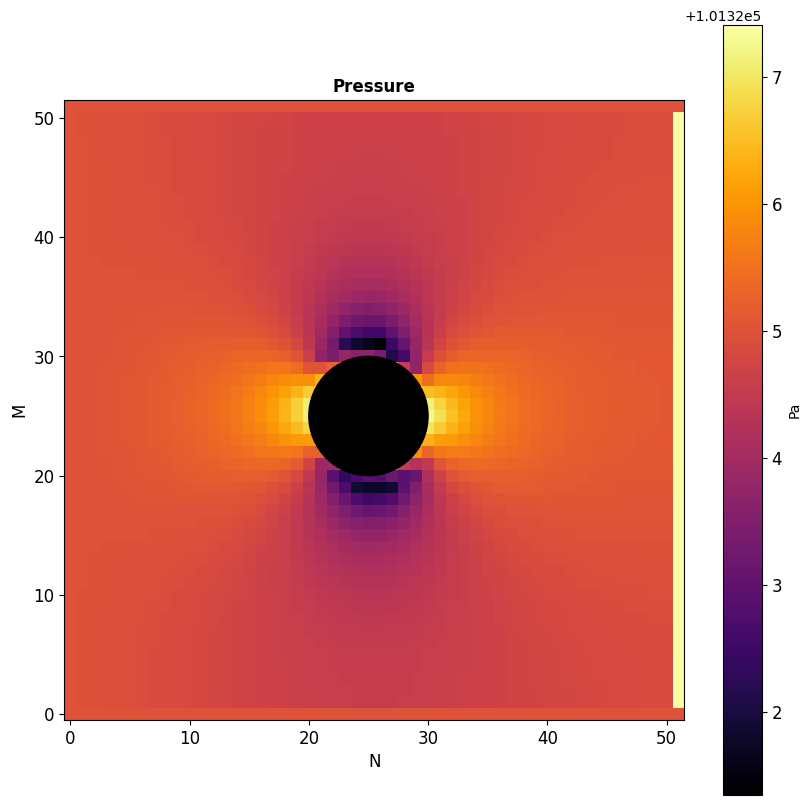

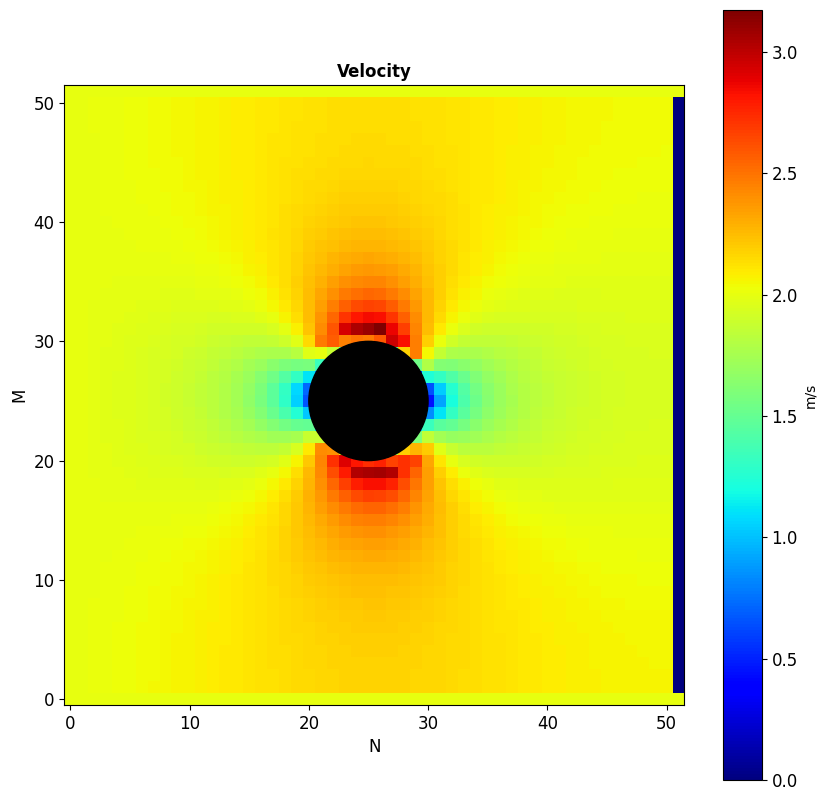

3.0892682756980547
3.060644699575462


In [49]:
# Specific Heat
c_P = 1034.09 - 2.849*(10**(-1))*T_in+7.817*(10**(-4))*T_in**2-4.971*(10**(-7))*T_in**3

# Temperature, Pressure & Density
T = np.zeros((M+2, N+2))
P = np.zeros((M+2, N+2))

for i in range (0, N+2):
    for j in range (0, M+2):
        T[j][i] = T_in + (V_in**2 - V_P[j][i]**2)/(2*c_P)
        P[j][i] = P_in * (T[j][i]/T_in)**(gamma/(gamma-1))
        Rho[j][i] = P[j][i]/(287.1*T[j][i])

# Temperature Plot

plt.figure(figsize=(10, 10))
circle = plt.Circle((N/2, M/2), (D*N)/(2*L), color='black', fill=True)
plt.gca().add_patch(circle)
plt.imshow(T, cmap='jet', origin = 'lower')
plt.colorbar(label='K', format = '%.3f').ax.tick_params(labelsize=12)
plt.title('Temperature', fontweight='bold')
plt.gca().tick_params(axis='both', labelsize=12)
plt.xlabel('N', fontsize = 12)
plt.ylabel('M', fontsize = 12)

plt.show()

# Pressure Plot
plt.figure(figsize=(10, 10))
circle = plt.Circle((N/2, M/2), (D*N)/(2*L), color='black', fill=True)
plt.gca().add_patch(circle)
plt.imshow(P, cmap='inferno', origin = 'lower')
plt.colorbar(label='Pa').ax.tick_params(labelsize=12)
plt.title('Pressure', fontweight='bold')
plt.gca().tick_params(axis='both', labelsize=12)
plt.xlabel('N', fontsize = 12)
plt.ylabel('M', fontsize = 12)

plt.show()

# Velocity

plt.figure(figsize=(10, 10))
circle = plt.Circle((N/2, M/2), (D*N)/(2*L), color='black', fill=True)
plt.gca().add_patch(circle)
plt.imshow(V_P, cmap='jet', origin='lower')
plt.colorbar(label='m/s').ax.tick_params(labelsize=12)
plt.title('Velocity', fontweight='bold')
plt.gca().tick_params(axis='both', labelsize=12)
plt.xlabel('N', fontsize = 12)
plt.ylabel('M', fontsize = 12)

plt.show()

print(V_P[int(M/2 + (D/2)*M/H) + 1][int(N/2)])
print(V_P[int(M/2 - (D/2)*M/H) - 1][int(N/2)])
#print(V_P[30][30])
#print(T[37][30])
#print(T[23][30])


DRAG AND LIFT

20265.356260164306
------------------------------
20265.42892138632
------------------------------
20265.41815210768
------------------------------
20265.332512752066
------------------------------
20265.05525976963
------------------------------
20265.33579671209
------------------------------
20265.26685356369
------------------------------
20265.000701876168
------------------------------
20264.970202434513
------------------------------
20264.758051768615
------------------------------
-20264.90467311986
-20264.51718621394
-20265.068658168464
-20265.267953343668
-20265.0973042891
-20264.972643050707
-20265.332290685074
-20265.382648842322
-20265.35204443887
-20265.275245742705
0.7520646404300351
1.8959372463359614


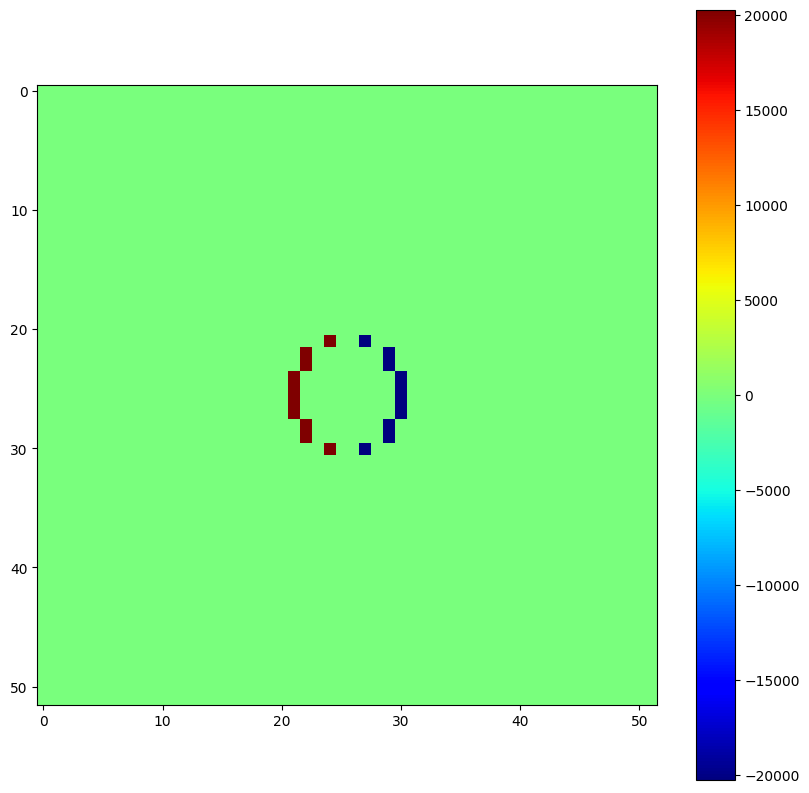

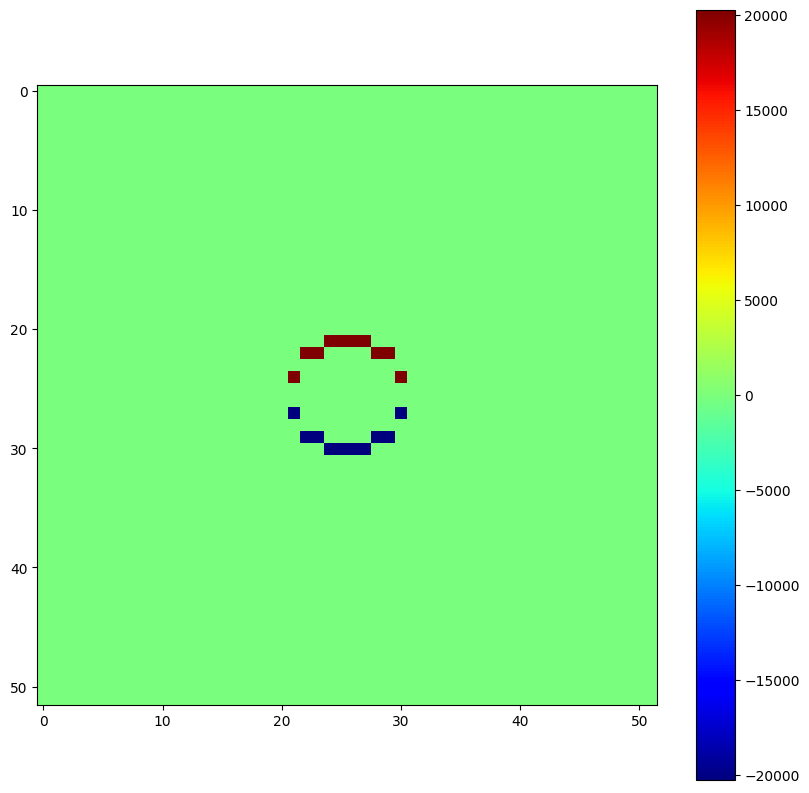

In [50]:
drag = np.zeros((M+2, N+2))
lift = np.zeros((M+2, N+2))
drag_tot = 0.0
lift_tot = 0.0

# Drag
for i in range (N+2):
    for j in range (M+2):
        if I_cyl[j][i] == 1 and I_cyl[j][i-1] == 0 :
            #lift[j][i] = P[j+1][i]*delta_M - P[j-1][i]*delta_M 
            drag[j][i] = P[j][i-1]*delta_M
            print(drag[j][i])
            print('------------------------------')
        
        if I_cyl[j][i] == 1 and I_cyl[j][i+1] == 0 :
            drag[j][i] = -P[j][i+1]*delta_M
            print(drag[j][i])

        drag_tot = drag[j][i] + drag_tot


# Lift
for i in range (N+2):
    for j in range (M+2):
        if I_cyl[j][i] == 1 and I_cyl[j-1][i] == 0 :
            #lift[j][i] = P[j+1][i]*delta_M - P[j-1][i]*delta_M 
            lift[j][i] = P[j-1][i]*delta_N
            
        if I_cyl[j][i] == 1 and I_cyl[j+1][i] == 0 :
            lift[j][i] = -P[j+1][i]*delta_N

        lift_tot = lift[j][i] + lift_tot

print(drag_tot)
print(lift_tot)
plt.figure(figsize=(10, 10))
plt.imshow(drag, cmap = 'jet')
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(lift, cmap = 'jet')
plt.colorbar()
plt.show()

